  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


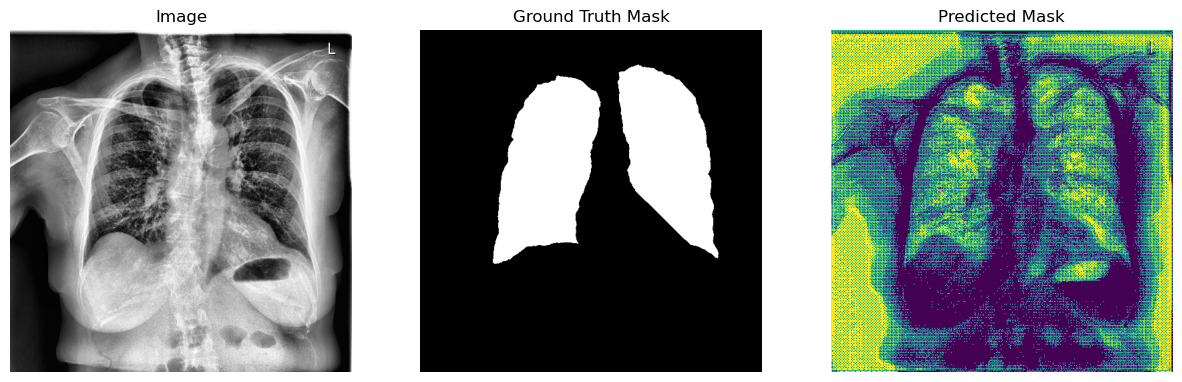

 20%|████████████████▊                                                                   | 1/5 [00:05<00:20,  5.03s/it]

1/1 [==============================] - 4s 4s/step


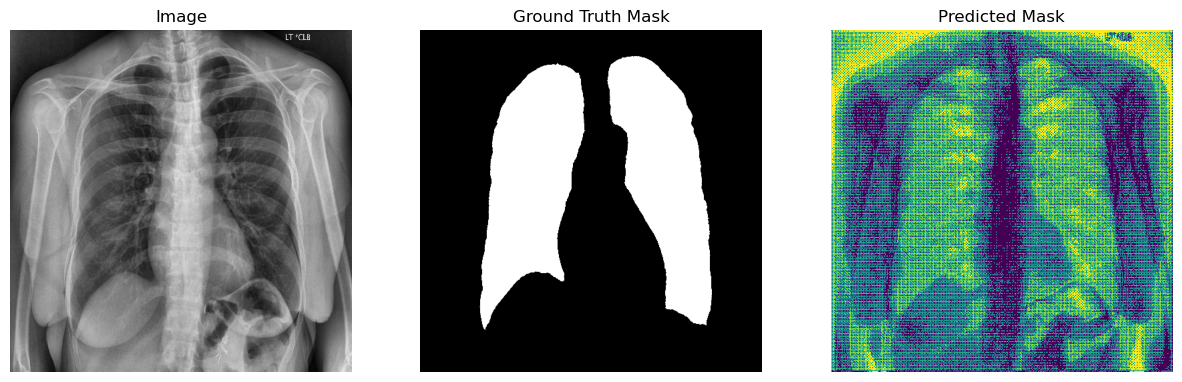

 40%|█████████████████████████████████▌                                                  | 2/5 [00:09<00:14,  4.84s/it]

1/1 [==============================] - 4s 4s/step


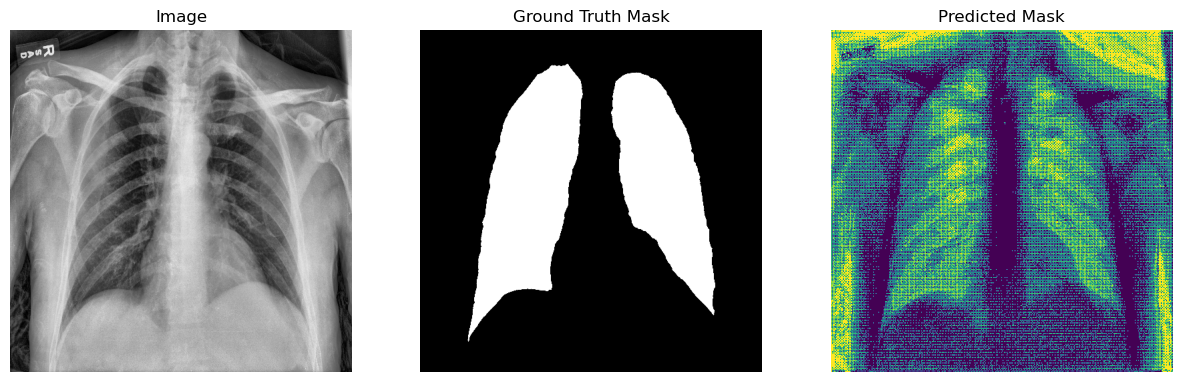

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:14<00:09,  4.65s/it]

1/1 [==============================] - 4s 4s/step


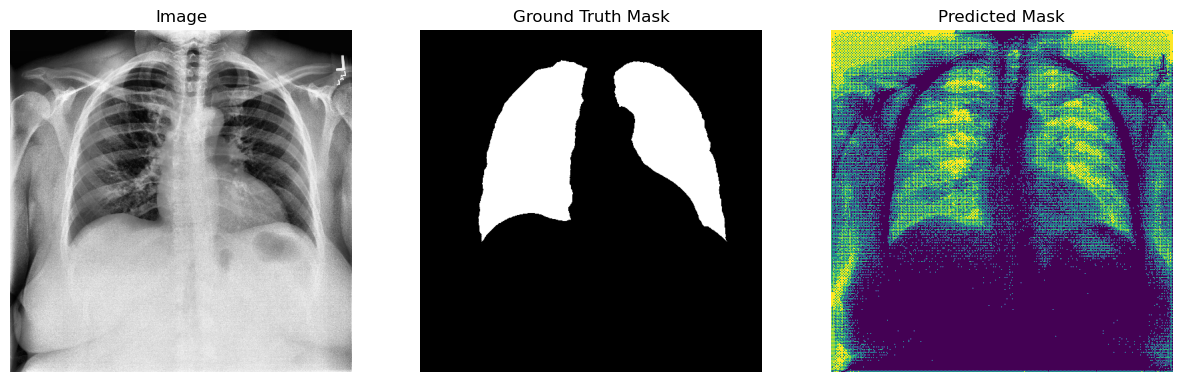

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:18<00:04,  4.57s/it]

1/1 [==============================] - 4s 4s/step


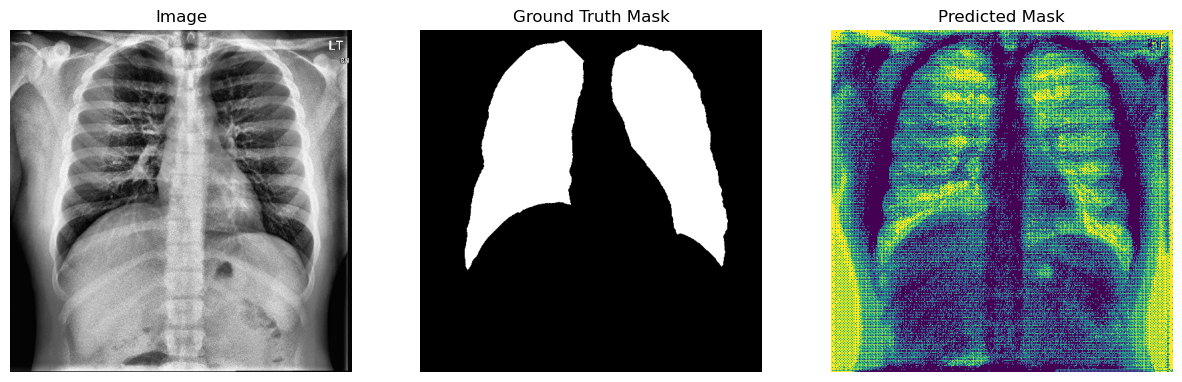

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.63s/it]


In [4]:
import import_ipynb
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from metrics import dice_loss, dice_coef, iou
from train1 import load_data, create_dir, tf_dataset
import matplotlib.pyplot as plt

H = 512
W = 512

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.h5")

    """ Dataset """
    dataset_path = "C:\\Users\\IIITSKLM\\Desktop\\indiana"
    (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2) = load_data(dataset_path)

    """ Predicting the mask """
    for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
        ori_x = cv2.resize(ori_x, (W, H))
        x = ori_x/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
        ori_y2 = cv2.imread(y2, cv2.IMREAD_GRAYSCALE)
        ori_y = ori_y1 + ori_y2
        ori_y = cv2.resize(ori_y, (W, H))
        ori_y = np.expand_dims(ori_y, axis=-1)  ## (512, 512, 1)
        ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)  ## (512, 512, 3)

        """ Predicting the mask. """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Displaying the image, ground truth mask, and predicted mask """
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(cv2.cvtColor(ori_x, cv2.COLOR_BGR2RGB))
        ax[0].set_title("Image")
        ax[0].axis("off")
        ax[1].imshow(ori_y)
        ax[1].set_title("Ground Truth Mask")
        ax[1].axis("off")
        ax[2].imshow(y_pred * 255)
        ax[2].set_title("Predicted Mask")
        ax[2].axis("off")
        plt.show()
